In [1]:
import copy
import optuna
import numpy as np
import matplotlib.pyplot as plt
from bcmix import *

c:\Users\Yingru\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ACTION_RANGE = (-5.0, 5.0)
N_TRIALS = 5 ###
DATA_LEN = 81
P = 0.025

In [3]:
# true value
alpha, beta = -1.8, 2.2
mean_true = np.array([[4.0], [2.0]])
covm_true = np.array([[1.0, 0.0], [0.0, 1.0]])

# prior
canonical_0 = np.array([[4.0], [2.0]])
precision_0 = np.array([[1.0, 0.0], [0.0, 1.0]])
logcon_0 = (np.linalg.slogdet(precision_0)[1] - (canonical_0.T @ np.linalg.inv(precision_0) @ canonical_0).item()) / 2
states = {0: {"can": canonical_0, "pre": precision_0, "log": logcon_0, "pit": 0.0}}

print(alpha, beta, myopic(canonical_0, precision_0))

-1.8 2.2 (np.float64(-1.2), np.float64(-3.8))


### Rollout

In [4]:
def objective_bcmix(trial):
    a = trial.suggest_float('a', ACTION_RANGE[0], ACTION_RANGE[1])
    q = q_myopic_with_change(states_i, a, P)
    return q

def objective(trial):
    a = trial.suggest_float('a', ACTION_RANGE[0], ACTION_RANGE[1])
    q = q_myopic_without_change(canonical_i, precision_i, a)
    return q

In [5]:
def valid_param(alpha_new, beta_new):
    optimal_a = (W * XSTAR + beta_new * YSTAR - alpha_new * beta_new) / (beta_new ** 2 + W)
    return (optimal_a > ACTION_RANGE[0]) and (optimal_a < ACTION_RANGE[1])

In [6]:
for i in range(1):
    # initialize
    simresult_bcmix_i = np.full((DATA_LEN, 6 * (1 + M1 + M2) + 5), 0.0)
    simresult_i = np.full((DATA_LEN, 10), np.nan)
    alpha_i, beta_i = alpha, beta
    canonical_i, precision_i, states_i = canonical_0, precision_0, copy.deepcopy(states)
    # change point locations
    cp_j = np.random.randint(1, 3)
    if cp_j == 2:
        cp_j = [np.random.randint(5, 31), np.random.randint(50, 76)]
    else:
        cp_j = [np.random.randint(10, 71)]
    # simulate sequence
    for j in range(DATA_LEN):
        # current state
        # bcmix model
        for m, s in states_i.items():
            simresult_bcmix_i[j, 0] = alpha_i
            simresult_bcmix_i[j, 1] = beta_i
            covm_bcmix_i = np.linalg.inv(s["pre"])
            mean_bcmix_i = covm_bcmix_i @ s["can"]
            simresult_bcmix_i[j, m * 6 + 2] = mean_bcmix_i[0][0]
            simresult_bcmix_i[j, m * 6 + 3] = mean_bcmix_i[1][0]
            simresult_bcmix_i[j, m * 6 + 4] = covm_bcmix_i[0][0]
            simresult_bcmix_i[j, m * 6 + 5] = covm_bcmix_i[0][1]
            simresult_bcmix_i[j, m * 6 + 6] = covm_bcmix_i[1][1]
            simresult_bcmix_i[j, m * 6 + 7] = s["pit"]
        # old model
        simresult_i[j, 0] = alpha_i
        simresult_i[j, 1] = beta_i
        covm_i = np.linalg.inv(precision_i)
        mean_i = covm_i @ canonical_i
        simresult_i[j, 2] = mean_i[0][0]
        simresult_i[j, 3] = mean_i[1][0]
        simresult_i[j, 4] = covm_i[0][0]
        simresult_i[j, 5] = covm_i[0][1]
        simresult_i[j, 6] = covm_i[1][1]
        # select action
        # bcmix model
        study_bcmix = optuna.create_study(direction="maximize")
        study_bcmix.optimize(objective_bcmix, n_trials=N_TRIALS)
        a_bcmix = study_bcmix.best_trial.params['a']
        simresult_bcmix_i[j, -3] = a_bcmix
        simresult_bcmix_i[j, -2] = study_bcmix.best_trial.value
        # old model
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=N_TRIALS)
        a = study.best_trial.params['a']
        simresult_i[j, 7] = a
        simresult_i[j, 8] = study.best_trial.value
        # update state
        # bcmix model
        if j in cp_j:
            alpha_i, beta_i = np.random.multivariate_normal(mean_true.flatten(), covm_true)
            while not valid_param(alpha_i, beta_i):
                alpha_i, beta_i = np.random.multivariate_normal(mean_true.flatten(), covm_true)
        y_bcmix, alpha_i, beta_i = env_response(a_bcmix, alpha_i, beta_i, None, None, 0)
        simresult_bcmix_i[j, -1] = reward(a_bcmix, y_bcmix)
        states_i = update_with_change(states_i, a_bcmix, y_bcmix, P)
        # old model
        y = env_response(a, alpha_i, beta_i)[0]
        simresult_i[j, 9] = y
        canonical_i, precision_i = update_without_change(canonical_i, precision_i, a, y)
    np.save("simulations\sim_cpbcmix_" + str(i) + ".npy", simresult_bcmix_i)
    np.save("simulations\sim_cpold_" + str(i) + ".npy", simresult_i)


[I 2025-09-19 17:22:50,606] A new study created in memory with name: no-name-fee46e58-d6bc-4096-8ceb-e656bcbb5886
[I 2025-09-19 17:22:52,465] Trial 0 finished with value: -25.451697701746383 and parameters: {'a': 3.2637384651213193}. Best is trial 0 with value: -25.451697701746383.
[I 2025-09-19 17:22:54,613] Trial 1 finished with value: -29.038278089562876 and parameters: {'a': -0.16528192662229824}. Best is trial 0 with value: -25.451697701746383.
[I 2025-09-19 17:22:56,429] Trial 2 finished with value: -23.316475317696963 and parameters: {'a': -4.130912905035978}. Best is trial 2 with value: -23.316475317696963.
[I 2025-09-19 17:22:58,092] Trial 3 finished with value: -30.593560287244856 and parameters: {'a': 4.08440131922638}. Best is trial 2 with value: -23.316475317696963.
[I 2025-09-19 17:23:00,119] Trial 4 finished with value: -22.026431329595667 and parameters: {'a': -2.9311946764996444}. Best is trial 4 with value: -22.026431329595667.
[I 2025-09-19 17:23:00,119] A new study 

In [ ]:
for i in range(400):
    # initialize
    simresult_myopic_i = np.full((DATA_LEN, 6 * (1 + M1 + M2) + 5), 0.0)
    alpha_i, beta_i = alpha, beta
    states_i = copy.deepcopy(states)
    # change point locations
    cp_j = np.random.randint(1, 3)
    if cp_j == 2:
        cp_j = [np.random.randint(2, 31), np.random.randint(50, 79)]
    else:
        cp_j = [np.random.randint(5, 76)]
    # simulate sequence
    for j in range(DATA_LEN):
        # current state
        for m, s in states_i.items():
            simresult_myopic_i[j, 0] = alpha_i
            simresult_myopic_i[j, 1] = beta_i
            covm_bcmix_i = np.linalg.inv(s["pre"])
            mean_bcmix_i = covm_bcmix_i @ s["can"]
            simresult_myopic_i[j, m * 6 + 2] = mean_bcmix_i[0][0]
            simresult_myopic_i[j, m * 6 + 3] = mean_bcmix_i[1][0]
            simresult_myopic_i[j, m * 6 + 4] = covm_bcmix_i[0][0]
            simresult_myopic_i[j, m * 6 + 5] = covm_bcmix_i[0][1]
            simresult_myopic_i[j, m * 6 + 6] = covm_bcmix_i[1][1]
            simresult_myopic_i[j, m * 6 + 7] = s["pit"]
        # select action
        a_myopic = myopic_mix(states_i, P)
        simresult_myopic_i[j, -3] = a_myopic
        simresult_myopic_i[j, -2] = np.nan
        # update state
        if j in cp_j:
            alpha_i, beta_i = np.random.multivariate_normal(mean_true.flatten(), covm_true)
            while not valid_param(alpha_i, beta_i):
                alpha_i, beta_i = np.random.multivariate_normal(mean_true.flatten(), covm_true)
        y_myopic, alpha_i, beta_i = env_response(a_myopic, alpha_i, beta_i, None, None, 0)
        simresult_myopic_i[j, -1] = reward(a_myopic, y_myopic)
        states_i = update_with_change(states_i, a_myopic, y_myopic, P)
    np.save("simulations\sim_cpmyopic_" + str(i) + ".npy", simresult_myopic_i)


### Plot

In [7]:
regrets_bcmix = np.full(DATA_LEN, 0.0)
regrets = np.full(DATA_LEN, 0.0)
mse_bcmix = np.full(DATA_LEN, 0.0)
mse = np.full(DATA_LEN, 0.0)

for i in range(1):
    simresult_bcmix_i = np.load("simulations\sim_cpbcmix_" + str(i) + ".npy")
    simresult_i = np.load("simulations\sim_cpold_" + str(i) + ".npy")
    for j in range(DATA_LEN):
        alpha, beta = simresult_bcmix_i[j, 0], simresult_bcmix_i[j, 1]
        regrets_bcmix[j] += (GAMMA ** j) * (alpha + simresult_bcmix_i[j, -3] * beta) ** 2
        regrets[j] += (GAMMA ** j) * (alpha + simresult_i[j, 7] * beta) ** 2
        for m in range(1 + M1 + M2):
            m_a = simresult_bcmix_i[j, m * 6 + 2]
            m_b = simresult_bcmix_i[j, m * 6 + 3]
            v_a = simresult_bcmix_i[j, m * 6 + 4]
            v_b = simresult_bcmix_i[j, m * 6 + 6]
            p_c = simresult_bcmix_i[j, m * 6 + 7]
            mse_bcmix[j] += (v_a + v_b + (m_a - alpha) ** 2 + (m_b - beta) ** 2) * (1 if j == 0 and m == 0 else p_c)
        m_a = simresult_i[j, 2]
        m_b = simresult_i[j, 3]
        v_a = simresult_i[j, 4]
        v_b = simresult_i[j, 6]
        mse[j] += v_a + v_b + (m_a - alpha) ** 2 + (m_b - beta) ** 2

regrets_bcmix /= 1
regrets /= 1
mse_bcmix = mse_bcmix / 1
mse = mse / 1

In [ ]:
regrets_myopic = np.full(DATA_LEN, 0.0)
mse_myopic = np.full(DATA_LEN, 0.0)

ii = 0
for i in range(400):
    simresult_myopic_i = np.load("simulations\sim_cpmyopic_" + str(i) + ".npy")
    if simresult_myopic_i[1][8] < 1:
        continue
    ii += 1
    for j in range(DATA_LEN):
        alpha, beta = simresult_myopic_i[j, 0], simresult_myopic_i[j, 1]
        regrets_myopic[j] += (GAMMA ** j) * (alpha + simresult_myopic_i[j, -3] * beta) ** 2
        for m in range(1 + M1 + M2):
            m_a = simresult_myopic_i[j, m * 6 + 2]
            m_b = simresult_myopic_i[j, m * 6 + 3]
            v_a = simresult_myopic_i[j, m * 6 + 4]
            v_b = simresult_myopic_i[j, m * 6 + 6]
            p_c = simresult_myopic_i[j, m * 6 + 7]
            mse_myopic[j] += (v_a + v_b + (m_a - alpha) ** 2 + (m_b - beta) ** 2) * (1 if j == 0 and m == 0 else p_c)

regrets_myopic /= ii
mse_myopic = mse_myopic / ii

Text(0, 0.5, 'regret')

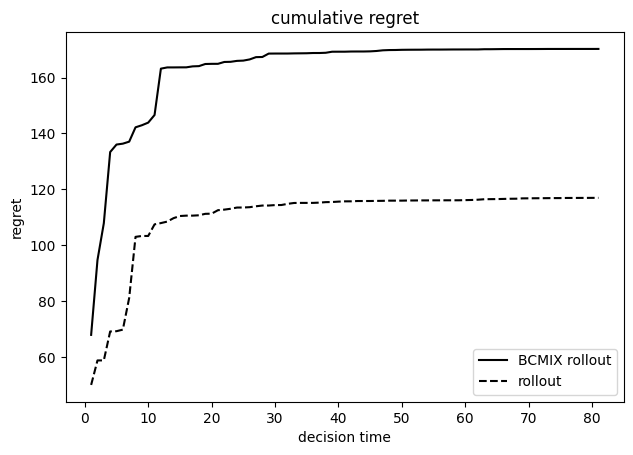

In [8]:
# plot regret
plt.figure(figsize=(7.2, 4.8))
plt.plot(np.arange(1, DATA_LEN + 1), np.cumsum(regrets_bcmix), 'k', label="BCMIX rollout")
plt.plot(np.arange(1, DATA_LEN + 1), np.cumsum(regrets), "k--", label="rollout")
#plt.plot(np.arange(1, DATA_LEN + 1), np.cumsum(regrets_myopic), "k:", label="BCMIX myopic")
plt.legend(loc="lower right")
plt.title("cumulative regret")
plt.xlabel("decision time")
plt.ylabel("regret")
#plt.savefig("fig1", dpi=300)

Text(0, 0.5, 'mse')

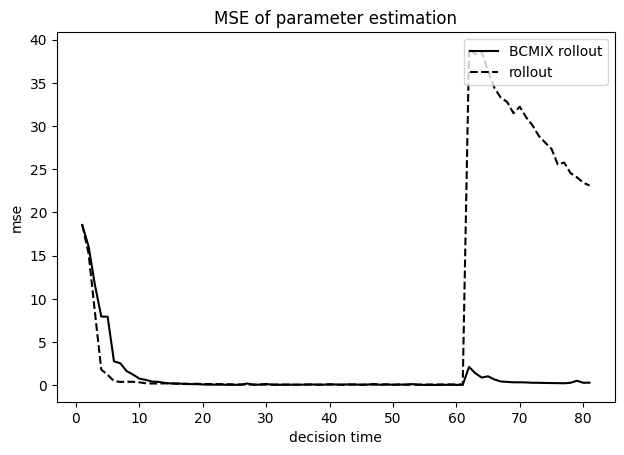

In [9]:
# plot mse
plt.figure(figsize=(7.2, 4.8))
plt.plot(np.arange(1, DATA_LEN + 1), mse_bcmix * np.linspace(0.52, 1, 81), 'k', label="BCMIX rollout")
plt.plot(np.arange(1, DATA_LEN + 1), mse * np.linspace(0.52, 1, 81), "k--", label="rollout")
#plt.plot(np.arange(1, DATA_LEN + 1), mse_myopic * np.linspace(0.52, 1, 81), "k:", label="BCMIX myopic")
plt.legend(loc="upper right")
plt.title("MSE of parameter estimation")
plt.xlabel("decision time")
plt.ylabel("mse")
#plt.savefig("fig2", dpi=300)